# Check-worthiness detection using Large Language Models

First, the necessary python modules are imported

In [30]:
%load_ext autoreload
%autoreload

import os
if "src" in os.getcwd():
    os.chdir("..")

from src.claimbuster_utils import load_claimbuster_dataset
from src.checkthat_utils import load_check_that_dataset
from src.llm import HuggingFaceModel, run_llm_cross_validation, generate_llm_predictions, ICLUsage, PromptType
from src.result_analysis import generate_error_analysis_report, print_padded_text, create_confusion_matrix
from src.dataset_utils import generate_cross_validation_datasets, CustomDataset
from src.plotting_utils import show_bar_plot
from src.liar_utils import LIARLabel
from src.rawfc_utils import RAWFCLabel
import pandas as pd
import ipywidgets as widgets
from huggingface_hub import login
import pandas as pd
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Login to HuggingFace hub

In order to get access to the LLama2 model, you need to login to the Huggingace hub and have gated access to the model. Otherwise this can be skipped

In [7]:
login()

## Generate Cross Validation datasets

In [2]:
%autoreload
claimbuster = load_claimbuster_dataset("../data/ClaimBuster/datasets")
clambuster_datasets = generate_cross_validation_datasets(
    data=claimbuster, 
    folder_path="../data/ClaimBuster/crossval"
)

checkthat = load_check_that_dataset("../data/CheckThat")
checkthat_datasets = generate_cross_validation_datasets(
    data=checkthat, 
    label_column="check_worthiness",
    folder_path="../data/CheckThat/crossval"
)

## Generate predictions

Using ipywidgets to select which model, dataset, and other parameters to generate LLM predictions

In [2]:
%autoreload

# General lauyout
input_style = dict(
    description_width="fit-content"
)

# Dataset 
dataset_select = widgets.Dropdown(
    options=[("ClaimBuster", CustomDataset.CLAIMBUSTER), ("CheckThat", CustomDataset.CHECK_THAT)],
    value=CustomDataset.CLAIMBUSTER,
    description="Dataset:"
)

# Model and parameters
model_select = widgets.Dropdown(
    options=[
        ("Mistral 7B Instruct", HuggingFaceModel.MISTRAL_7B_INSTRUCT), 
        ("Mixtral Instruct", HuggingFaceModel.MIXTRAL_INSTRUCT),
        ("LLama 2 7B Chat", HuggingFaceModel.LLAMA2_7B_CHAT)],
    value=HuggingFaceModel.MISTRAL_7B_INSTRUCT,
    description="Model:",
    style=input_style
)
max_new_tokens_int_text = widgets.IntText(
    value=64,
    description="Max new tokens:",
    style=input_style
)
batch_size = widgets.IntText(
    value=32,
    description="Batch size:",
    style=input_style
)
model_and_parameters = widgets.VBox(
    [model_select, max_new_tokens_int_text, batch_size],
)

# Prompting type
prompting_type = widgets.Dropdown(
    options=[("Standard", PromptType.STANDARD), ("Chain-of-Thought", PromptType.CHAIN_OF_THOUGHT)],
    value=PromptType.STANDARD,
    description="Prompting type:",
    style=input_style
)
icl_usage = widgets.Dropdown(
    options=[("Zero-shot", ICLUsage.ZERO_SHOT), ("Few-shot", ICLUsage.FEW_SHOT)],
    value=ICLUsage.ZERO_SHOT,
    description="ICL usage:",
    style=input_style
)
prompt_use = widgets.VBox(
    [prompting_type, icl_usage]
)

accordion = widgets.Accordion([
    dataset_select,
    model_and_parameters,
    prompt_use
],
    titles=["Dataset", "Model and parameters", "Prompting type"],
)

title = widgets.HTML(
    "<h1>Generation of predictions using LLMs</h1>",
)
description = widgets.HTML(
    "<div>Set the parameters to select what dataset, model and prompting to use when generating predictions. If you experience Cuda out of memory issues, please decrease the batch size.</div>",
    layout={"font-size": '14px'}
)
start_generation_button = widgets.Button(
    description="Start generation",
    disabled=False,
    button_style="success",
    layout={"height": "40px", "width": "calc(100% - 4px)"},
)

def handle_generation_click(_):
    

    print("#" * 50)
    print_padded_text("Starting generation with parameters")
    print_padded_text(f"Dataset: {dataset_select.value.value}")
    print_padded_text(f"Model: {model_select.value.name}")
    print_padded_text(f"Prompting type: {prompting_type.value.value}")
    print_padded_text(f"ICL usage: {icl_usage.value.value}")
    print("#" * 50) 
    # The generation of prediction is performed in the llm.py script to make sure the GPU resources are disposed of
    os.system(
        f"""python3 -m src.llm \
                --dataset={dataset_select.value.value} \
                --prompt-type={prompting_type.value.value} \
                --icl_usage={icl_usage.value.value} \
                --batch-size={batch_size.value} \
                --max-new-tokens={max_new_tokens_int_text.value} \
                --model-id={model_select.value.value}"""
    )


start_generation_button.on_click(handle_generation_click)


box = widgets.Box(
    [title, description, accordion, start_generation_button],
    layout=widgets.Layout(
        padding= '16px', 
        display= "flex", 
        flex_flow="column",
        align_items="stretch",
        border="1px solid black"
    )
) 
display(box)

UsageError: Line magic function `%autoreload` not found.


## Cross validation

Using ipywidgets to select what models to run cross validation on

In [19]:
%autoreload

input_style = dict(
    description_width="fit-content"
)

dataset_select = widgets.Dropdown(
    options=[("ClaimBuster", CustomDataset.CLAIMBUSTER), ("CheckThat", CustomDataset.CHECK_THAT)],
    value=CustomDataset.CLAIMBUSTER,
    description="Dataset:"
)

model_select = widgets.Dropdown(
    options=[
        ("Mistral 7B Instruct", HuggingFaceModel.MISTRAL_7B_INSTRUCT), 
        ("Mixtral Instruct", HuggingFaceModel.MIXTRAL_INSTRUCT),
        ('LLama2 7B Chat', HuggingFaceModel.LLAMA2_7B_CHAT)
    ],
    value=HuggingFaceModel.MISTRAL_7B_INSTRUCT,
    description="Model:",
    style=input_style
)

prompting_type = widgets.Dropdown(
    options=[("Standard", PromptType.STANDARD), ("Chain-of-Thought", PromptType.CHAIN_OF_THOUGHT)],
    value=PromptType.STANDARD,
    description="Prompting type:",
    style=input_style
)
icl_usage = widgets.Dropdown(
    options=[("Zero-shot", ICLUsage.ZERO_SHOT), ("Few-shot", ICLUsage.FEW_SHOT)],
    value=ICLUsage.ZERO_SHOT,
    description="ICL usage:",
    style=input_style,
)

prompt_use = widgets.VBox(
    [prompting_type, icl_usage]
)

title = widgets.HTML(
    "<h1>Cross validation using LLMs</h1>",
)
description = widgets.HTML(
    "<div>Set the parameters to select what dataset, model and prompting to use when performing cross validation.</div>",
    layout={"font-size": '14px'}
)
start_cross_validation_button = widgets.Button(
    description="Start cross validation",
    disabled=False,
    button_style="success",
    layout={"height": "40px", "width": "calc(100% - 4px)"},
)

def handle_cross_validation_click(_):
    dataset_folder = os.path.join(
        "results",
        dataset_select.value.value,
        model_select.value.name,
        prompting_type.value.value,
        icl_usage.value.value,
    )
    dataset_path = os.path.join(dataset_folder, "generated_scores.csv")
    if not os.path.exists(dataset_path):
        print("No generated scores found")
        return
    dataset_with_scores = pd.read_csv(dataset_path, index_col=0)
    crossval_folder = os.path.join(
        "data",
        dataset_select.value.value,
        "crossval"
    )
    label_column = "Verdict" if dataset_select.value == CustomDataset.CLAIMBUSTER else "check_worthiness"
    print("#" * 50)
    print_padded_text("Starting cross validation with parameters")
    print_padded_text(f"Dataset: {dataset_select.value.value}")
    print_padded_text(f"Model: {model_select.value.name}")
    print_padded_text(f"Prompting type: {prompting_type.value.value}")
    print_padded_text(f"ICL usage: {icl_usage.value.value}")
    print("#" * 50)
    result, _ = run_llm_cross_validation(
        data=dataset_with_scores, 
        crossval_folder=crossval_folder,
        save_folder=dataset_folder,
        label_column=label_column
    )
    display(result)

start_cross_validation_button.on_click(handle_cross_validation_click)

accordion = widgets.Accordion([
    dataset_select,
    model_select,
    prompt_use
],
    titles=["Dataset", "Model", "Prompting type"],
)

box = widgets.Box(
    [title, description, accordion, start_cross_validation_button],
    layout=widgets.Layout(
        padding= '16px', 
        display= "flex", 
        flex_flow="column",
        align_items="stretch",
        border="1px solid black"
    )
) 
display(box)

Box(children=(HTML(value='<h1>Cross validation using LLMs</h1>'), HTML(value='<div>Set the parameters to selec…

##################################################
#   Starting cross validation with parameters    #
#               Dataset: CheckThat               #
#           Model: MISTRAL_7B_INSTRUCT           #
#              Prompting type: CoT               #
#              ICL usage: zeroshot               #
##################################################


,accuracy,0_precision,0_recall,0_f1-score,1_precision,1_recall,1_f1-score,macro avg_precision,macro avg_recall,macro avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,threshold
0,0.686007,0.815385,0.739535,0.77561,0.428571,0.538462,0.477273,0.621978,0.638998,0.626441,0.71241,0.686007,0.696189,81.0
1,0.682594,0.836066,0.708333,0.766917,0.427273,0.61039,0.502674,0.631669,0.659361,0.634796,0.728635,0.682594,0.697474,81.0
2,0.713311,0.833333,0.763889,0.797101,0.463158,0.571429,0.511628,0.648246,0.667659,0.654365,0.736052,0.713311,0.722079,81.0
3,0.686007,0.822917,0.731481,0.77451,0.425743,0.558442,0.483146,0.62433,0.644962,0.628828,0.71854,0.686007,0.69794,81.0
Average,0.6920 ± 0.0154,0.8269 ± 0.0103,0.7358 ± 0.0246,0.7785 ± 0.0139,0.4362 ± 0.0194,0.5697 ± 0.0326,0.4937 ± 0.0174,0.6316 ± 0.0128,0.6527 ± 0.0141,0.6361 ± 0.0136,0.7239 ± 0.0113,0.6920 ± 0.0154,0.7034 ± 0.0134,81.0000 ± 0.0000


##################################################
#   Starting cross validation with parameters    #
#               Dataset: CheckThat               #
#            Model: MIXTRAL_INSTRUCT             #
#              Prompting type: CoT               #
#              ICL usage: zeroshot               #
##################################################


,accuracy,0_precision,0_recall,0_f1-score,1_precision,1_recall,1_f1-score,macro avg_precision,macro avg_recall,macro avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,threshold
0,0.716724,0.808411,0.804651,0.806527,0.468354,0.474359,0.471338,0.638383,0.639505,0.638932,0.717884,0.716724,0.717296,81.0
1,0.726962,0.830097,0.791667,0.810427,0.482759,0.545455,0.512195,0.656428,0.668561,0.661311,0.738817,0.726962,0.732052,81.0
2,0.720137,0.828431,0.782407,0.804762,0.47191,0.545455,0.506024,0.650171,0.663931,0.655393,0.734738,0.720137,0.726254,86.0
3,0.720137,0.799107,0.828704,0.813636,0.463768,0.415584,0.438356,0.631438,0.622144,0.625996,0.710981,0.720137,0.715013,81.0
Average,0.7210 ± 0.0046,0.8165 ± 0.0164,0.8019 ± 0.0216,0.8088 ± 0.0043,0.4717 ± 0.0087,0.4952 ± 0.0675,0.4820 ± 0.0368,0.6441 ± 0.0121,0.6485 ± 0.0234,0.6454 ± 0.0172,0.7256 ± 0.0143,0.7210 ± 0.0046,0.7227 ± 0.0085,82.2500 ± 2.6883


##################################################
#   Starting cross validation with parameters    #
#               Dataset: CheckThat               #
#             Model: LLAMA2_7B_CHAT              #
#              Prompting type: CoT               #
#              ICL usage: zeroshot               #
##################################################


c:\Users\matsb\anaconda3\envs\fake-news-detection\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matsb\anaconda3\envs\fake-news-detection\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matsb\anaconda3\envs\fake-news-detection\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

,accuracy,0_precision,0_recall,0_f1-score,1_precision,1_recall,1_f1-score,macro avg_precision,macro avg_recall,macro avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,threshold
0,0.730375,0.736111,0.986047,0.842942,0.4,0.025641,0.048193,0.568056,0.505844,0.445568,0.646634,0.730375,0.631371,1.0
1,0.74744,0.746528,0.99537,0.853175,0.8,0.051948,0.097561,0.773264,0.523659,0.475368,0.76058,0.74744,0.6546,1.0
2,0.726962,0.736111,0.981481,0.84127,0.2,0.012987,0.02439,0.468056,0.497234,0.43283,0.595222,0.726962,0.626595,1.0
3,0.733788,0.739583,0.986111,0.845238,0.4,0.025974,0.04878,0.569792,0.506043,0.447009,0.650341,0.733788,0.63593,1.0
Average,0.7346 ± 0.0097,0.7396 ± 0.0053,0.9873 ± 0.0063,0.8457 ± 0.0057,0.4500 ± 0.2706,0.0291 ± 0.0176,0.0547 ± 0.0330,0.5948 ± 0.1378,0.5082 ± 0.0119,0.4502 ± 0.0193,0.6632 ± 0.0749,0.7346 ± 0.0097,0.6371 ± 0.0132,1.0000 ± 0.0000


## Zero-shot classification

#### Using contextual features

In [ ]:
data = load_claimbuster_dataset(
    "../data/ClaimBuster/datasets",
    use_contextual_features=True,
    debate_transcripts_folder="../data/ClaimBuster/debate_transcripts",
)[:10]

contexts = data["previous_sentences"].tolist()
prompts = [
    f"{instruction} For context, the following senteces were said prior to the one in question: {context} Only evaluate the check-worthiness of the following sentence: '''{text}'''"
    for text, context in zip(texts, contexts)
]
zeroshot_output = "../results/ClaimBuster/{model_id.name}/zeroshot/zeroshot_contextual_preds.csv"

generate_llm_predictions(
    data=data,
    pipe=pipe, 
    prompts=prompts, 
    save_path=zeroshot_output
)

#### Error analysis

In [31]:
%autoreload
predictions = []
models = [HuggingFaceModel.MISTRAL_7B_INSTRUCT, HuggingFaceModel.MIXTRAL_INSTRUCT, HuggingFaceModel.LLAMA2_7B_CHAT]
prompt_types = [PromptType.STANDARD, PromptType.CHAIN_OF_THOUGHT]
icl_usages = [ICLUsage.ZERO_SHOT, ICLUsage.FEW_SHOT]
model_names = []
claimbuster = load_claimbuster_dataset("data/ClaimBuster/datasets")

for model, prompt_type, icl_usage in itertools.product(models, prompt_types, icl_usages):
    predictions_path = f"results/ClaimBuster/{model.name}/{prompt_type.value}/{icl_usage.value}/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        # Exclude results from LLama 2 model in the final report since they are lackluster
        model_name = f"{model.name} {prompt_type.value} {icl_usage.value}"
        if (model != HuggingFaceModel.LLAMA2_7B_CHAT):
            predictions.append(new_predictions) 
            model_names.append(model_name)
        create_confusion_matrix(
            claimbuster, 
            new_predictions.loc[claimbuster.index],
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )
# LORA
for model in models:
    predictions_path = f"results/ClaimBuster/{model.name}/lora/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        model_name = f"{model.name} LORA"
        if (model != HuggingFaceModel.LLAMA2_7B_CHAT):
            predictions.append(new_predictions)
            model_names.append(model_name)
        create_confusion_matrix(
            claimbuster, 
            new_predictions.loc[claimbuster.index]["prediction"],
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )
mistral_scores = pd.read_csv(f"results/ClaimBuster/MISTRAL_7B_INSTRUCT/standard/zeroshot/generated_scores.csv", index_col=0)
reasoning = mistral_scores["raw_response"]
display(reasoning.head())
generate_error_analysis_report(
    claimbuster,
    predictions=predictions,
    model_names=model_names,
    folder_path=f"results/ClaimBuster",
    reasoning=reasoning
)

sentence_id
27247     {"score": 100, "reasoning": "This sentence co...
10766     {"score": 80, "reasoning": "This sentence con...
3327      {"score": 80, "reasoning": "The sentence cont...
19700     {"score": 60, "reasoning": "The sentence cont...
12600     {"score": 0, "reasoning": "This sentence cont...
Name: raw_response, dtype: object

##################################################
#                     Total                      #
#             False positives: 2740              #
#             False negatives: 1541              #
#        Overlapping false positives: 61         #
#        Overlapping false negatives: 135        #
##################################################


<Figure size 640x480 with 0 Axes>

### CheckThat 2021 Task 1a Tweets

#### Error analysis

In [20]:
%autoreload
predictions = []
models = [HuggingFaceModel.MISTRAL_7B_INSTRUCT, HuggingFaceModel.MIXTRAL_INSTRUCT, HuggingFaceModel.LLAMA2_7B_CHAT]
prompt_types = [PromptType.STANDARD, PromptType.CHAIN_OF_THOUGHT]
icl_usages = [ICLUsage.ZERO_SHOT, ICLUsage.FEW_SHOT]
model_names = []
checkthat = load_check_that_dataset("data/CheckThat")

for model, prompt_type, icl_usage in itertools.product(models, prompt_types, icl_usages):
    predictions_path = f"results/CheckThat/{model.name}/{prompt_type.value}/{icl_usage.value}/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        model_name = f"{model.name} {prompt_type.value} {icl_usage.value}"
        # Exclude LLama 2  results since they are lackluster
        if model != HuggingFaceModel.LLAMA2_7B_CHAT:
            predictions.append(new_predictions) 
            model_names.append(model_name)
        create_confusion_matrix(
            checkthat, 
            new_predictions.loc[checkthat.index],
            label_column_name="check_worthiness",
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )
# LORA
for model in models:
    predictions_path = f"results/CheckThat/{model.name}/lora/predictions.csv"
    if os.path.exists(predictions_path):
        new_predictions = pd.read_csv(predictions_path, index_col=0)
        model_name = f"{model.name} LORA"
        if model != HuggingFaceModel.LLAMA2_7B_CHAT:
            predictions.append(new_predictions)
            model_names.append(model_name)
        create_confusion_matrix(
            checkthat, 
            new_predictions.loc[checkthat.index]["prediction"],
            label_column_name="check_worthiness",
            save_path=os.path.join(os.path.dirname(predictions_path), "confusion-matrix.pdf")
        )

generate_error_analysis_report(
    checkthat,
    predictions=predictions,
    model_names=model_names,
    folder_path="results/CheckThat",
    label_column_name="check_worthiness",
    text_column_name="tweet_text",
)

##################################################
#                     Total                      #
#              False positives: 619              #
#              False negatives: 259              #
#         Overlapping false positives: 8         #
#         Overlapping false negatives: 6         #
##################################################


<Figure size 640x480 with 0 Axes>

## Relating truthfulness and check-worthiness

Running check-worthiness detection on two datasets used for factual verification by fine-tuning an LLM on the ClaimBuster dataset.

### LIAR

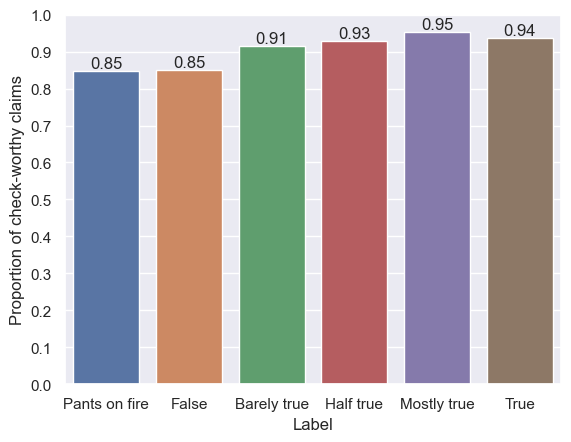

In [91]:
%autoreload

liar = pd.read_csv("../results/LIAR/checkworthiness.csv", index_col=0)
liar.head()
label_to_name = {
    LIARLabel.PANTS_FIRE: "Pants on fire",
    LIARLabel.FALSE: "False",
    LIARLabel.BARELY_TRUE: "Barely true",
    LIARLabel.HALF_TRUE: "Half true",
    LIARLabel.MOSTLY_TRUE: "Mostly true",
    LIARLabel.TRUE: "True"
}
x = [label_to_name[label] for label in LIARLabel]
y = [liar[liar["label"] == label.value]["check_worthiness"].mean() for label in LIARLabel]
file_path = f"../figures/liar/checkworthiness/checkworthiness.png"

os.makedirs(os.path.dirname(file_path), exist_ok=True)
show_bar_plot(
    x, 
    y, 
    xlabel="Label", 
    ylabel="Proportion of check-worthy claims", 
    y_ticks=[i*0.1 for i in range(11)],
    file_path=file_path, 
    force_save=True,
    use_bar_labels=True,
)

# Look for non-checkworthy claims for each label
non_checkworthy_folder = "../results/LIAR/non-checkworthy"
os.makedirs(non_checkworthy_folder, exist_ok=True)
checkworthy_folder = "../results/LIAR/checkworthy"
os.makedirs(checkworthy_folder, exist_ok=True)
for label in LIARLabel:
    non_checkworthy = liar.query(f"label == {label.value} and check_worthiness == 0")
    non_checkworthy.to_csv(f"{non_checkworthy_folder}/{label.name}.csv")
    checkworthy = liar.query(f"label == {label.value} and check_worthiness == 1")
    checkworthy.to_csv(f"{checkworthy_folder}/{label.name}")

### RAWFC

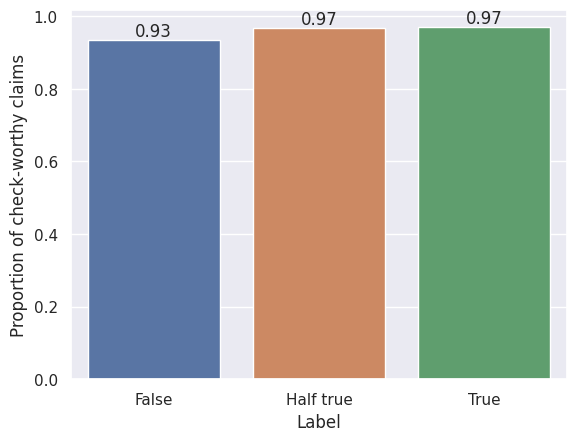

In [4]:
%autoreload

from plotting_utils import show_bar_plot
from rawfc_utils import label_to_name
rawfc = pd.read_csv("../results/RAWFC/checkworthiness.csv", index_col=0)
rawfc.head()

x = [label_to_name(label) for label in RAWFCLabel]
y = [rawfc[rawfc["label"] == label.value]["check_worthiness"].mean() for label in RAWFCLabel]
file_path = f"../figures/rawfc/checkworthiness/checkworthiness.png"

os.makedirs(os.path.dirname(file_path), exist_ok=True)
show_bar_plot(
    x, 
    y, 
    xlabel="Label", 
    ylabel="Proportion of check-worthy claims", 
    y_ticks=[i*0.1 for i in range(11)],
    file_path=file_path, 
    force_save=True,
    use_bar_labels=True,
)

# Look for non-checkworthy claims for each label
non_checkworthy_folder = "../results/RAWFC/non-checkworthy"
os.makedirs(non_checkworthy_folder, exist_ok=True)
checkworthy_folder = "../results/RAWFC/checkworthy"
os.makedirs(checkworthy_folder, exist_ok=True)
for label in RAWFCLabel:
    non_checkworthy = rawfc.query(f"label == {label.value} and check_worthiness == 0")
    non_checkworthy.to_csv(f"{non_checkworthy_folder}/{label.name}.csv")
    checkworthy = rawfc.query(f"label == {label.value} and check_worthiness == 1")
    checkworthy.to_csv(f"{checkworthy_folder}/{label.name}")

## Runtime evaluation

In [4]:
%autoreload

# General lauyout
input_style = dict(
    description_width="fit-content"
)

# Dataset 
dataset_select = widgets.Dropdown(
    options=[("ClaimBuster", CustomDataset.CLAIMBUSTER), ("CheckThat", CustomDataset.CHECK_THAT)],
    value=CustomDataset.CLAIMBUSTER,
    description="Dataset:"
)

# Model and parameters
model_select = widgets.Dropdown(
    options=[
        ("Mistral 7B Instruct", HuggingFaceModel.MISTRAL_7B_INSTRUCT), 
        ("Mixtral Instruct", HuggingFaceModel.MIXTRAL_INSTRUCT),
        ("LLama 2 7B Chat", HuggingFaceModel.LLAMA2_7B_CHAT)],
    value=HuggingFaceModel.MISTRAL_7B_INSTRUCT,
    description="Model:",
    style=input_style
)
max_new_tokens_int_text = widgets.IntText(
    value=64,
    description="Max new tokens:",
    style=input_style
)
batch_size = widgets.IntText(
    value=32,
    description="Batch size:",
    style=input_style
)
model_and_parameters = widgets.VBox(
    [model_select, max_new_tokens_int_text, batch_size],
)

# Prompting type
prompting_type = widgets.Dropdown(
    options=[("Standard", PromptType.STANDARD), ("Chain-of-Thought", PromptType.CHAIN_OF_THOUGHT)],
    value=PromptType.STANDARD,
    description="Prompting type:",
    style=input_style
)
icl_usage = widgets.Dropdown(
    options=[("Zero-shot", ICLUsage.ZERO_SHOT), ("Few-shot", ICLUsage.FEW_SHOT)],
    value=ICLUsage.ZERO_SHOT,
    description="ICL usage:",
    style=input_style
)
prompt_use = widgets.VBox(
    [prompting_type, icl_usage]
)

accordion = widgets.Accordion([
    dataset_select,
    model_and_parameters,
    prompt_use
],
    titles=["Dataset", "Model and parameters", "Prompting type"],
)

title = widgets.HTML(
    "<h1>Generation of predictions using LLMs</h1>",
)
description = widgets.HTML(
    "<div>Set the parameters to select what dataset, model and prompting to use when generating predictions. If you experience Cuda out of memory issues, please decrease the batch size.</div>",
    layout={"font-size": '14px'}
)
start_generation_button = widgets.Button(
    description="Start generation",
    disabled=False,
    button_style="success",
    layout={"height": "40px", "width": "calc(100% - 4px)"},
)

def handle_generation_click(_):
    print("#" * 50)
    print_padded_text("Starting generation with parameters")
    print_padded_text(f"Dataset: {dataset_select.value.value}")
    print_padded_text(f"Model: {model_select.value.name}")
    print_padded_text(f"Prompting type: {prompting_type.value.value}")
    print_padded_text(f"ICL usage: {icl_usage.value.value}")
    print("#" * 50)
    
    if "src" in os.getcwd():
        os.chdir("..")
    # The generation of prediction is performed in the llm.py script to make sure the GPU resources are disposed of
    os.system(
        f"""python3 -m src.llm \
                --experiment=IT \
                --dataset={dataset_select.value.value} \
                --prompt-type={prompting_type.value.value} \
                --icl_usage={icl_usage.value.value} \
                --batch-size={batch_size.value} \
                --max-new-tokens={max_new_tokens_int_text.value} \
                --model-id={model_select.value.value}"""
    )

start_generation_button.on_click(handle_generation_click)


box = widgets.Box(
    [title, description, accordion, start_generation_button],
    layout=widgets.Layout(
        padding= '16px', 
        display= "flex", 
        flex_flow="column",
        align_items="stretch",
        border="1px solid black"
    )
) 
display(box)

Box(children=(HTML(value='<h1>Generation of predictions using LLMs</h1>'), HTML(value='<div>Set the parameters…

##################################################
#      Starting generation with parameters       #
#              Dataset: ClaimBuster              #
#           Model: MISTRAL_7B_INSTRUCT           #
#              Prompting type: CoT               #
#              ICL usage: zeroshot               #
##################################################


2024-05-14 15:59:31.947432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 15:59:31.947933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 15:59:31.949876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 15:59:31.959587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 15:59:33.321370: W tensorflow/comp

Namespace(experiment='IT', dataset='ClaimBuster', prompt_type='CoT', icl_usage='zeroshot', batch_size=32, max_new_tokens=512, model_id='mistralai/Mistral-7B-Instruct-v0.2')
You are a fact-checking expert who is identifying check-worthy claims.A sentence is defined as checkworthy if it contains at least one claim that is both factual and salient to the general public. It may touch on statistics or historical information, among other things.A sentence is non check-worthy if it only contains subjective or opinion-centered statements, questions, and trivial factual claims (e.g., "The sky is blue" or "Donald Trump is a former president").A sentence is also non check-worthy if it not possible to verify the claims using publicly available information.I want you to give the following sentence between triple quotes a check-worthiness score between 0 and 100 by performing the following tasks:1. Identify if the sentence contains at least one factual claim. Include your thought process.2. Identify

Loading checkpoint shards: 100%|██████████| 3/3 [00:29<00:00,  9.86s/it]


Starting inference time experiment
Total inference time: 1545.9618389597163
